# Process NASA Hazard and Disaster Risk Data
*Link NASA Earth Data Hazards and Disaster Risk* <br>
https://sedac.ciesin.columbia.edu/theme/hazards/data/sets/browse

In [2]:
import pandas as pd
pd.set_option('display.max_columns',None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../')
from utils import summary

In [4]:
df = pd.read_csv("../../../Common_Repository/exposure_data_v3.csv")
df.drop(['ORDER_NUM', 'ENDOR_NUM', 
       'COUNTRY', 'STATE', 'COUNTY', 'CITY_NAME', 'ZIP_CD', 'ACCURACY_VALIDATE', 'EXTERNAL_REFERENCE', 'GEO_CD',
       'OCCUPANCY_SCHEMA', 'OCCUPANCY_CD', 'OCCUPANCY_SOURCE',
       'CONSTRUCTION_SCHEMA', 'CONSTRUCTION_CD', 'CONSTRUCTION_SOURCE',
       'YR_BLT', 'NO_OF_STRY', 'NO_OF_BLDG', 'SITE_CCY_CD', 
       'FOR_INTEREST', 'BI_TYPE',  'MPL_PD',
       'MPL_PD_PERCEN', 'MPL_PD_TYPE', 'MPL_BI', 'MPL_BI_PERCEN',
       'MPL_BI_TYPE', 'FMLS_PD', 'FMLS_PD_PERCEN', 'FMLS_PD_TYPE', 'FMLS_BI',
       'FMLS_BI_PERCEN', 'FMLS_BI_TYPE', 'COVERAGE_TYPE', 'CATEGORY',
       'SUB_CATEGORY', 'ASSET_QUALITY', 'MB_QUALIFIER',
       'LARGEST_UNIT_CAPACITY', 'OP_STATUS'  ],axis=1,inplace=True)

In [5]:
summary(df)

,Type,unique value,Available Value,% Availability
Column name,,,,
FACUL_NUM,object,4472,7299519,100.00
YEAR,int64,4,7299519,100.00
DIVISION_NUM,int64,12,7299519,100.00
LATITUDE,float64,1249,7299519,100.00
LONGITUDE,float64,3007,7299519,100.00
IV_BUILDING,float64,1382418,7153099,97.99
IV_CONTENT,float64,1623655,7164038,98.14
IV_PD,float64,1943195,7297421,99.97
IV_BI_VAL,float64,710363,2276404,31.19


## Extract data

In [6]:
def extract_data(filename):
    f = open(filename,'r')
    lines = f.readlines()
    for i in range(6):
        print(lines[i])

    nc = int(lines[0].split(' ')[-1].strip())
    nr = int(lines[1].split(' ')[-1].strip())

    data = np.zeros(shape=(nr,nc))
    for i in range(nr):
        line = lines[6+i]
        values = list(map(lambda x: float(x.strip()),line.split(' ')[:-1]))
        data[i] = values
    data = np.where(data==-9999, 0, data)
    
    y0 = float(lines[2].split(' ')[-1].strip())
    x0 = float(lines[3].split(' ')[-1].strip())
    step = float(lines[4].split(' ')[-1].strip())
    return data ,x0, y0, step

ncols         8640

nrows         3432

xllcorner     -180

yllcorner     -58.015072

cellsize      0.0416666666667

NODATA_value  -9999



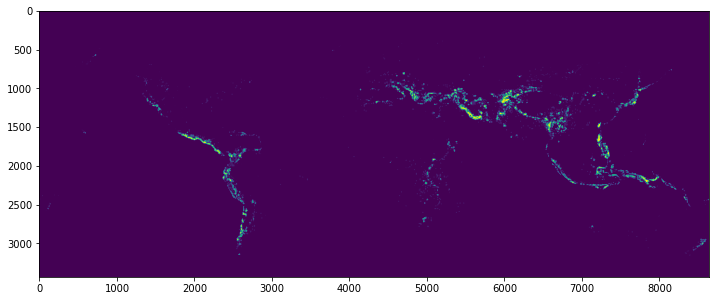

In [9]:
data_eq, x0_eq, y0_eq, step_eq = extract_data('../../01_Data/01_Raw/GlobalNatCatGrids/gdeqk/gdeqk.asc')
plt.figure(figsize=(12,12))
plt.imshow(data_eq)

ncols         8633

nrows         3430

xllcorner     -179.9984

yllcorner     -58.015072

cellsize      0.0417

NODATA_value  -9999



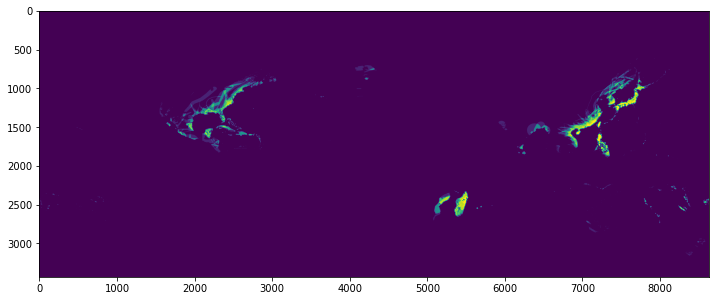

In [10]:
data_cyc, x0_cyc, y0_cyc, step_cyc = extract_data('../../01_Data/01_Raw/GlobalNatCatGrids/gdcyc/gdcyc.asc')
plt.figure(figsize=(12,12))
plt.imshow(data_cyc)

ncols         8633

nrows         3430

xllcorner     -179.9984

yllcorner     -58.015072

cellsize      0.0417

NODATA_value  -9999



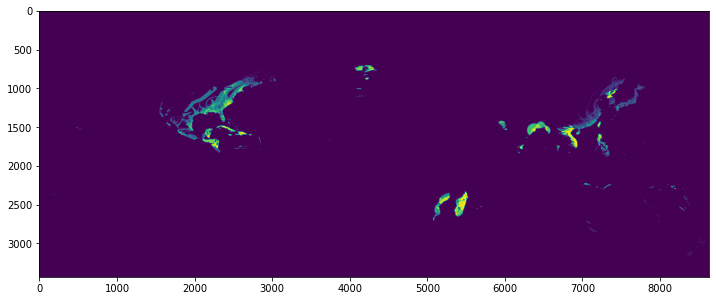

In [11]:
data_cycpro, x0_cycp, y0_cycp, step_cycp = extract_data('../../01_Data/01_Raw/GlobalNatCatGrids/gdcycpro/gdcycpro.asc')
plt.figure(figsize=(12,12))
plt.imshow(data_cycpro)

ncols         8640

nrows         3432

xllcorner     -180

yllcorner     -58.015072

cellsize      0.0416666666667

NODATA_value  -9999



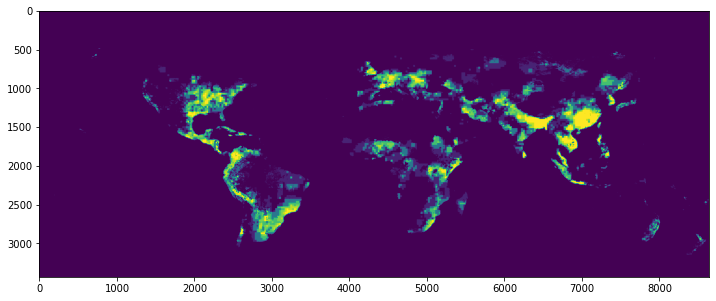

In [12]:
data_fld, x0_fld, y0_fld, step_fld = extract_data('../../01_Data/01_Raw/GlobalNatCatGrids/gdfld/gdfld.asc')
plt.figure(figsize=(12,12))
plt.imshow(data_fld)

ncols         8633

nrows         3430

xllcorner     -179.9984

yllcorner     -58.0161

cellsize      0.0417

NODATA_value  -9999



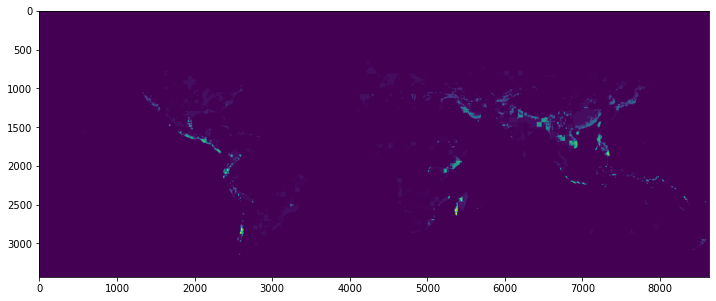

In [13]:
data_mhz, x0_mhz, y0_mhz, step_mhz = extract_data('../../01_Data/01_Raw/GlobalNatCatGrids/gdmhz/gdmhz.asc')
plt.figure(figsize=(12,12))
plt.imshow(data_mhz)

ncols         8633

nrows         3430

xllcorner     -179.9984

yllcorner     -58.015072

cellsize      0.0417

NODATA_value  -9999



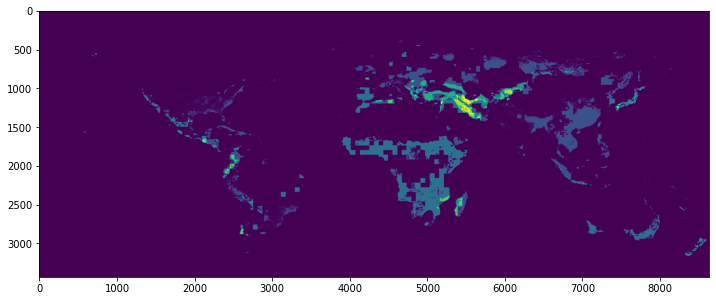

In [16]:
data_mhzpro,x0_mhzp,y0_mhzp,step_mhzp = extract_data('../../01_Data/01_Raw/GlobalNatCatGrids/gdmhzpro/gdmhzpro.asc')
plt.figure(figsize=(12,12))
plt.imshow(data_mhzpro)

ncols         8640

nrows         3432

xllcorner     -180

yllcorner     -58.015072

cellsize      0.0416666666667

NODATA_value  -9999



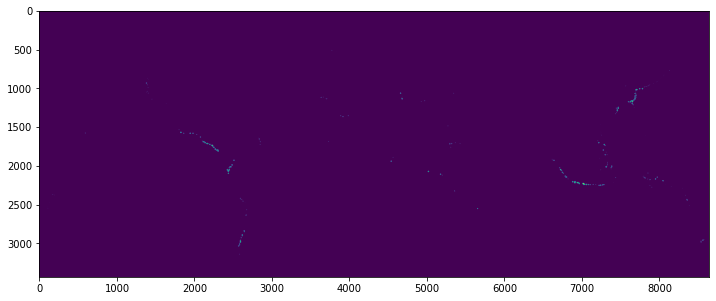

In [17]:
data_vol, x0_vol, y0_vol, step_vol = extract_data('../../01_Data/01_Raw/GlobalNatCatGrids/gdvol/gdvol.asc')
plt.figure(figsize=(12,12))
plt.imshow(data_vol)

## Merge with SCOR data

In [23]:
def create_feature(data, feature_name, x0, y0, step, df, g):
    
    exposure = pd.DataFrame(columns=['FACUL_NUM','YEAR','DIVISION_NUM',feature_name])

    for k, i in g.groups.items():
        dt = df.iloc[i.values].reset_index()

        X = (dt.LATITUDE - x0) / step
        Y = (dt.LONGITUDE - y0) / step
        X = X.astype('int')
        Y = Y.astype('int')
        VALS = data[X,Y]

        score = 0
        for index, row in dt.iterrows():
            if np.isnan(row['TIV']):
                score += (row['IV_PD'] + row['IV_BI_VAL']) * VALS[index] * row['INTEREST_DECLARATION']
            else:
                score += (row['TIV'] ) * VALS[index] * row['INTEREST_DECLARATION']
        if VALS.sum() != 0:
            score = score / max(VALS)
        exposure = exposure.append({'FACUL_NUM':k[0],'YEAR':k[1],'DIVISION_NUM':k[2],feature_name:score},ignore_index=True) 
    return exposure

In [24]:
df[['IV_PD', 'IV_BI_VAL', 'TIV']] = df[['IV_PD', 'IV_BI_VAL', 'TIV']].fillna(0)
g = df.groupby(['FACUL_NUM','YEAR','DIVISION_NUM'])

In [25]:
df_eq = create_feature(data_eq,'EARTHQ_EXP',x0_eq,y0_eq,step_eq,df,g)
df_cyc = create_feature(data_cyc,'CYC_EXP',x0_cyc,y0_cyc,step_cyc,df,g)
df_cycp = create_feature(data_cycpro,'CYCPRO_EXP',x0_cycp,y0_cycp,step_cycp,df,g)
df_fld = create_feature(data_fld,'FLD_EXP',x0_fld,y0_fld,step_fld,df,g)
df_mhz = create_feature(data_mhz,'MHZ_EXP',x0_mhz,y0_mhz,step_mhz,df,g)
df_mhzp = create_feature(data_mhzpro,'MHZPRO_EXP',x0_mhzp,y0_mhzp,step_mhzp,df,g)
df_vol = create_feature(data_vol,'VOL_EXP',x0_vol,y0_vol,step_vol,df,g)

<AxesSubplot:ylabel='Frequency'>

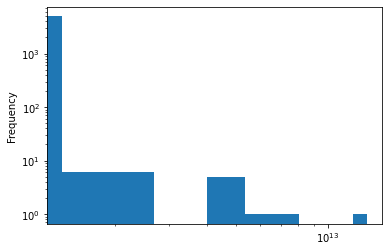

In [56]:
plt.yscale('log')
plt.xscale('log')
df_mhzp.MHZPRO_EXP.plot.hist()

In [27]:
df_ = df_eq.merge(df_cyc,on=['FACUL_NUM','YEAR','DIVISION_NUM'])
df_ = df_.merge(df_cycp,on=['FACUL_NUM','YEAR','DIVISION_NUM'])
df_ = df_.merge(df_fld,on=['FACUL_NUM','YEAR','DIVISION_NUM'])
df_ = df_.merge(df_mhz,on=['FACUL_NUM','YEAR','DIVISION_NUM'])
df_ = df_.merge(df_mhzp,on=['FACUL_NUM','YEAR','DIVISION_NUM'])
df_ = df_.merge(df_vol,on=['FACUL_NUM','YEAR','DIVISION_NUM'])

In [28]:
df_.head()

,FACUL_NUM,YEAR,DIVISION_NUM,EARTHQ_EXP,CYC_EXP,CYCPRO_EXP,FLD_EXP,MHZ_EXP,MHZPRO_EXP,VOL_EXP
0,01F009143,2017,1,0.0,0.0,0.0,0.00e+00,0.00e+00,0.00e+00,0.0
1,01F009143,2018,1,0.0,0.0,0.0,0.00e+00,0.00e+00,0.00e+00,0.0
2,01F009143,2019,1,0.0,0.0,0.0,0.00e+00,0.00e+00,0.00e+00,0.0
3,01F012384,2017,1,0.0,0.0,0.0,8.74e+07,3.36e+08,6.41e+08,0.0
4,01F012384,2018,1,0.0,0.0,0.0,1.25e+08,9.00e+08,1.20e+09,0.0


In [29]:
df_[['EARTHQ_EXP','CYC_EXP','CYCPRO_EXP','FLD_EXP','MHZ_EXP','MHZPRO_EXP','VOL_EXP']] = df_[['EARTHQ_EXP','CYC_EXP','CYCPRO_EXP','FLD_EXP','MHZ_EXP','MHZPRO_EXP','VOL_EXP']].apply(lambda x : x**.2)

In [33]:
df_.to_csv('../../01_Data//02_Processed/hazard_disaster_risk_v2.csv', index=False)